In [1]:
! pip install evaluate
! git clone https://github.com/ohmeow/blurr.git
%cd blurr
! pip install -e ".[dev]"

! pip install -q onnxruntime onnxruntime-gpu onnxruntime_tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
Cloning into 'blurr'...
remote: Enumerating objects: 5397, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (360/360), done.
remote: Total 5397 (delta 895), reused 1140 (delta 837), pack-reused 4173 (from 1)
Receiving objects: 100% (5397/5397), 36.45 MiB | 37.90 MiB/s, done.
Resolving deltas: 100% (4126/4126), done.
/kaggle/working/blurr
Obtaining file:///kaggle/working/blurr
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with o

In [2]:
# Part 1: Update seq2seq/core.py
# Replace deprecated datasets.load_metric with evaluate library
# This update is needed because load_metric was removed in newer versions of datasets
with open('/kaggle/working/blurr/blurr/text/modeling/seq2seq/core.py', 'r') as file:
   content = file.read()
# Replace old import statement with new evaluate import
new_content = content.replace(
   'from datasets import load_metric as hf_load_metric', # Old import using deprecated load_metric
   'import evaluate'                                     # New import using evaluate library
)
# Write updated content back to file
with open('/kaggle/working/blurr/blurr/text/modeling/seq2seq/core.py', 'w') as file:
   file.write(new_content)

# Part 2: Update question_answering.py 
# Replace deprecated load_metric and update squad metric initialization
with open('/kaggle/working/blurr/blurr/text/modeling/question_answering.py', 'r') as file:
   content = file.read()
# Make two replacements:
# 1. Update the import statement
# 2. Update how the squad metric is loaded
new_content = content.replace(
   'from datasets import load_metric',                   # Old import statement
   'import evaluate'                                     # New evaluate import
).replace(
   'squad_metric = load_metric("squad")',               # Old way of loading squad metric
   'squad_metric = evaluate.load("squad")'              # New way using evaluate.load()
)
# Write the updated content back to file
with open('/kaggle/working/blurr/blurr/text/modeling/question_answering.py', 'w') as file:
   file.write(new_content)

In [3]:
import sys
sys.path.append("/kaggle/working/blurr/")
from blurr.text.modeling.core import BaseModelWrapper
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *
from fastai.text.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from PIL import Image
from wordcloud import WordCloud,STOPWORDS
from itertools import chain
from collections import Counter
import torch
%matplotlib inline
import evaluate
from sklearn.metrics import f1_score
metric = evaluate.load("squad")

In [4]:
df=pd.read_csv("/kaggle/input/comprehensive-goodreads-book-dataset/book_details.csv")

In [5]:
mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/twitter.png"))

In [6]:
df.head()

,title,url,description,genres
0,To Kill a Mockingbird,https://www.goodreads.com/book/show/2657.To_Kill_a_Mockingbird,"The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it. ""To Kill A Mockingbird"" became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic.Compassionate, dramatic, and deeply moving, ""To Kill A Mockingbird"" takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pathos. Now with over 18 million copies in print and transla...","['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Read For School', 'Novels', 'High School']"
1,Harry Potter and the Philosopher’s Stone,https://www.goodreads.com/book/show/72193.Harry_Potter_and_the_Philosopher_s_Stone,"Harry Potter thinks he is an ordinary boy - until he is rescued by an owl, taken to Hogwarts School of Witchcraft and Wizardry, learns to play Quidditch and does battle in a deadly duel. The Reason ... HARRY POTTER IS A WIZARD!","['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Classics', 'Adventure', 'Audiobook', 'Science Fiction Fantasy']"
2,Pride and Prejudice,https://www.goodreads.com/book/show/1885.Pride_and_Prejudice,"Alternate cover edition of ISBN 9780679783268Since its immediate success in 1813, Pride and Prejudice has remained one of the most popular novels in the English language. Jane Austen called this brilliant work ""her own darling child"" and its vivacious heroine, Elizabeth Bennet, ""as delightful a creature as ever appeared in print."" The romantic clash between the opinionated Elizabeth and her proud beau, Mr. Darcy, is a splendid performance of civilized sparring. And Jane Austen's radiant wit sparkles as her characters dance a delicate quadrille of flirtation and intrigue, making this book t...","['Classics', 'Fiction', 'Romance', 'Historical Fiction', 'Literature', 'Historical', 'Audiobook', 'Novels', 'Historical Romance', 'Adult']"
3,The Diary of a Young Girl,https://www.goodreads.com/book/show/48855.The_Diary_of_a_Young_Girl,"Discovered in the attic in which she spent the last years of her life, Anne Frank’s remarkable diary has become a world classic—a powerful reminder of the horrors of war and an eloquent testament to the human spirit.In 1942, with the Nazis occupying Holland, a thirteen-year-old Jewish girl and her family fled their home in Amsterdam and went into hiding. For the next two years, until their whereabouts were betrayed to the Gestapo, the Franks and another family lived cloistered in the “Secret Annexe” of an old office building. Cut off from the outside world, they faced hunger, boredom, the ...","['Classics', 'Nonfiction', 'History', 'Biography', 'Memoir', 'Historical', 'Holocaust']"
4,Animal Farm,https://www.goodreads.com/book/show/170448.Animal_Farm,"Librarian's note: There is an Alternate Cover Edition for this edition of this book here.A farm is taken over by its overworked, mistreated animals. With flaming idealism and stirring slogans, they set out to create a paradise of progress, justice, and equality. Thus the stage is set for one of the most telling satiric fables ever penned –a razor-edged fairy tale for grown-ups that records the evolution from revolution against tyranny to a totalitarianism just as terrible.When was first published, Stalinist Russia was seen as its target. Today it is devastatingly clear that wherever and wh...","['Classics', 'Fiction', 'Dystopia', 'Fantasy', 'Politics', 'Literature', 'School', 'Science Fiction', 'Novels', 'Read For School']"


In [7]:
df.shape

(6313, 4)

In [8]:
df.isnull().sum()

title           0
url             0
description    39
genres          0
dtype: int64

In [9]:
df = df.dropna().reset_index(drop=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6274 entries, 0 to 6273
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        6274 non-null   object
 1   url          6274 non-null   object
 2   description  6274 non-null   object
 3   genres       6274 non-null   object
dtypes: object(4)
memory usage: 196.2+ KB


In [11]:
df.drop(columns=["url"],axis=1,inplace=True)

In [12]:
df["text"]=df["title"]+" "+df["description"]

In [13]:
df.drop(columns=["title","description"],axis=1,inplace=True)

In [14]:
df.head()

,genres,text
0,"['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Read For School', 'Novels', 'High School']","To Kill a Mockingbird The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it. ""To Kill A Mockingbird"" became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic.Compassionate, dramatic, and deeply moving, ""To Kill A Mockingbird"" takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pathos. Now with over 18 million copie..."
1,"['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Classics', 'Adventure', 'Audiobook', 'Science Fiction Fantasy']","Harry Potter and the Philosopher’s Stone Harry Potter thinks he is an ordinary boy - until he is rescued by an owl, taken to Hogwarts School of Witchcraft and Wizardry, learns to play Quidditch and does battle in a deadly duel. The Reason ... HARRY POTTER IS A WIZARD!"
2,"['Classics', 'Fiction', 'Romance', 'Historical Fiction', 'Literature', 'Historical', 'Audiobook', 'Novels', 'Historical Romance', 'Adult']","Pride and Prejudice Alternate cover edition of ISBN 9780679783268Since its immediate success in 1813, Pride and Prejudice has remained one of the most popular novels in the English language. Jane Austen called this brilliant work ""her own darling child"" and its vivacious heroine, Elizabeth Bennet, ""as delightful a creature as ever appeared in print."" The romantic clash between the opinionated Elizabeth and her proud beau, Mr. Darcy, is a splendid performance of civilized sparring. And Jane Austen's radiant wit sparkles as her characters dance a delicate quadrille of flirtation and intrigue..."
3,"['Classics', 'Nonfiction', 'History', 'Biography', 'Memoir', 'Historical', 'Holocaust']","The Diary of a Young Girl Discovered in the attic in which she spent the last years of her life, Anne Frank’s remarkable diary has become a world classic—a powerful reminder of the horrors of war and an eloquent testament to the human spirit.In 1942, with the Nazis occupying Holland, a thirteen-year-old Jewish girl and her family fled their home in Amsterdam and went into hiding. For the next two years, until their whereabouts were betrayed to the Gestapo, the Franks and another family lived cloistered in the “Secret Annexe” of an old office building. Cut off from the outside world, they f..."
4,"['Classics', 'Fiction', 'Dystopia', 'Fantasy', 'Politics', 'Literature', 'School', 'Science Fiction', 'Novels', 'Read For School']","Animal Farm Librarian's note: There is an Alternate Cover Edition for this edition of this book here.A farm is taken over by its overworked, mistreated animals. With flaming idealism and stirring slogans, they set out to create a paradise of progress, justice, and equality. Thus the stage is set for one of the most telling satiric fables ever penned –a razor-edged fairy tale for grown-ups that records the evolution from revolution against tyranny to a totalitarianism just as terrible.When was first published, Stalinist Russia was seen as its target. Today it is devastatingly clear that whe..."


In [15]:
df["genres"].value_counts()

genres
[]                                                                                                                                                   155
['Fiction']                                                                                                                                           12
['Nonfiction']                                                                                                                                        12
['Fiction', 'Young Adult', 'Childrens', 'Middle Grade', 'Fantasy', 'Mystery', 'Adventure', 'Audiobook', 'Humor', 'Juvenile']                          10
['Fantasy']                                                                                                                                            8
                                                                                                                                                    ... 
['Nonfiction', 'Memoir', 'Psychology', 'Mental Health', 'Mental Illness', '

In [16]:
genre_count = df["genres"].explode().value_counts()
print(genre_count.describe())


count    5866.000000
mean        1.069553
std         2.039074
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       155.000000
Name: count, dtype: float64


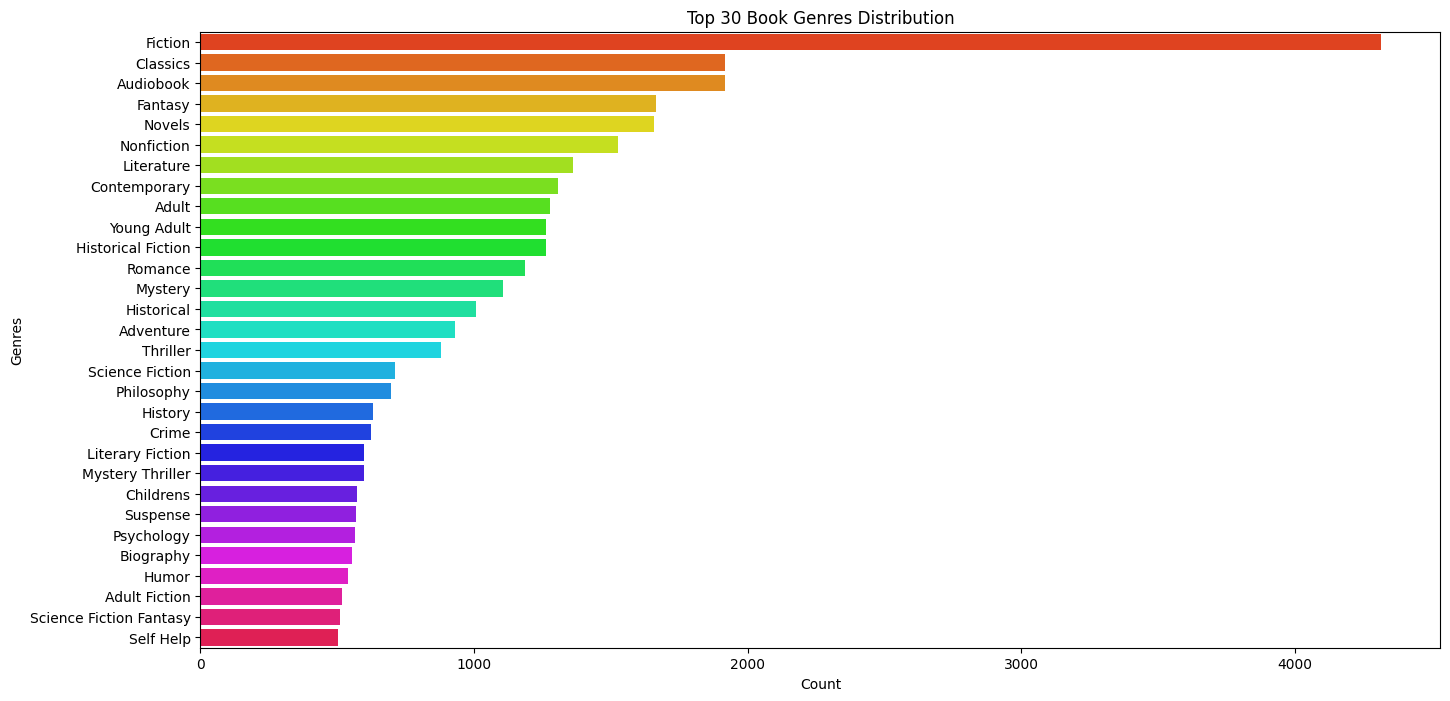

In [17]:
genre_count = [g for genres in df["genres"] for g in eval(genres)]
genre_series = pd.Series(genre_count)
genre_counts = genre_series.value_counts().head(30)

plt.figure(figsize=(16, 8))
sns.barplot(y=genre_counts.index, x=genre_counts.values, palette="hsv")
plt.xlabel("Count")
plt.ylabel("Genres")
plt.title("Top 30 Book Genres Distribution")
plt.show()

In [18]:
df1=df.copy()

# Clean Data

In [19]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from bs4 import BeautifulSoup

def clean_text(text):
    if isinstance(text, str):
        text = BeautifulSoup(text, 'html.parser').get_text()
        text = re.sub(r"[^a-zA-Z]", " ", text)
        text = text.translate(str.maketrans("", "", string.punctuation))

        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"
                                   u"\U0001F300-\U0001F5FF"
                                   u"\U0001F680-\U0001F6FF"
                                   u"\U0001F1E0-\U0001F1FF"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        text = re.sub(r"#.*", "", text)
        text = re.sub(r"/\*.*?\*/", "", text, flags=re.DOTALL)
        text = text.lower()

       
        nltk_stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in nltk_stop_words]

        text = ' '.join(tokens)

        return text
    else:
        return ""

In [20]:
df["text"]=df["text"].apply(clean_text)

# Book Description WordCloud

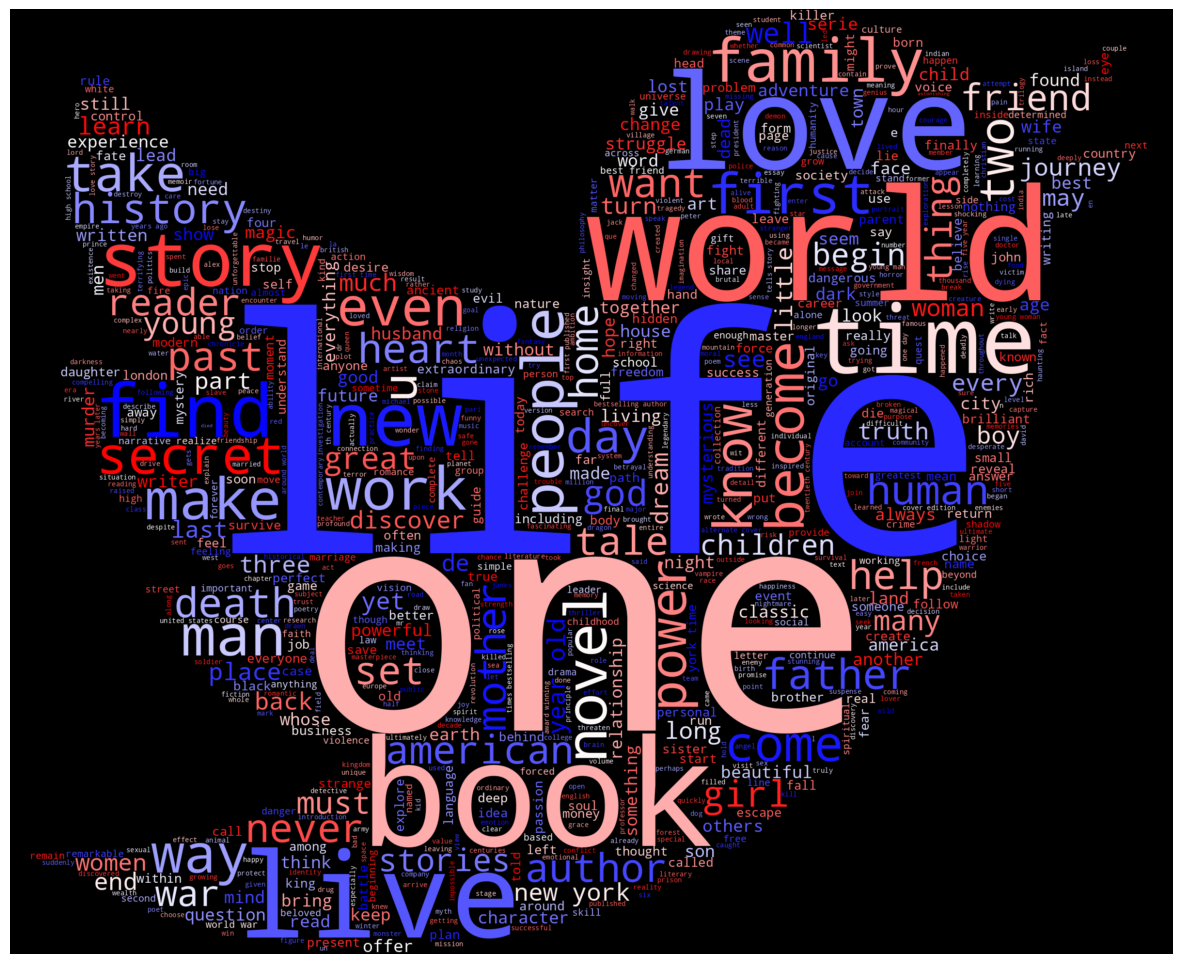

In [21]:

plt.figure(figsize=(15,15))
all_text=" ".join(df['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="bwr",mask=mask).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Book Genres WordCloud

<Figure size 1500x1500 with 0 Axes>

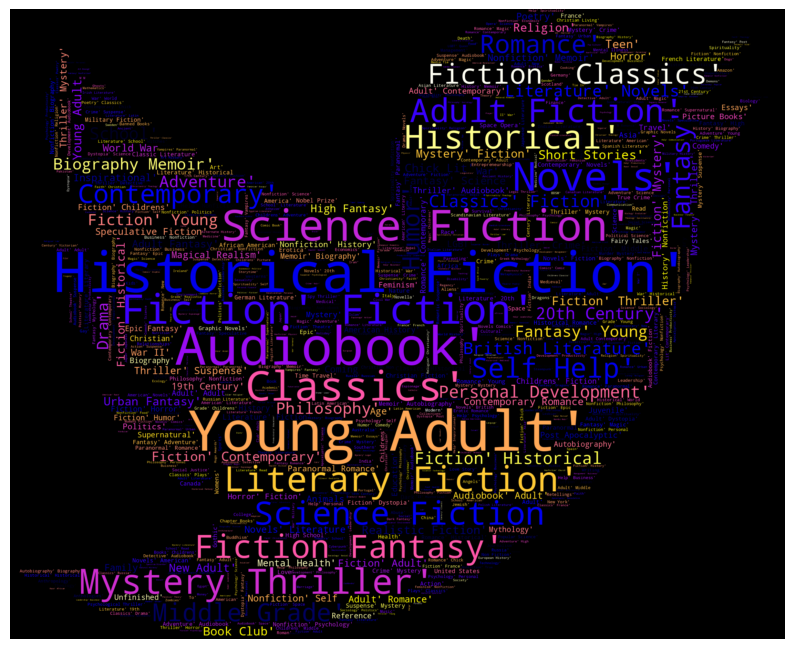

In [22]:

plt.figure(figsize=(15,15))

all_text = " ".join(df['genres'].values.tolist())
wordcloud = WordCloud(width=800, height=800, stopwords=STOPWORDS,mask=mask, background_color='black', max_words=800, colormap="gnuplot2").generate(all_text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Rare Genres

In [23]:
import ast
df["genres"] = df["genres"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
genre_count = df["genres"].explode().value_counts()
threshold = 11
rare_genres = [key for key, value in genre_count.items() if value < threshold]
print("Length of rare genres:", len(rare_genres))
print(f"Rare genres are: {rare_genres}")

Length of rare genres: 318
Rare genres are: ['Zen', 'Futuristic', 'Historical Fantasy', 'Amish', 'Turkish', 'Turkish Literature', 'Personal Finance', 'Horses', 'Superheroes', 'Cozy Mystery', 'Native Americans', 'Language', 'Tragedy', 'Art Design', 'Teaching', 'Cults', 'Sustainability', 'American Revolution', 'Aviation', 'Foodie', 'Swedish Literature', 'Adoption', 'Hinduism', 'Cats', 'Christian Fantasy', 'Utopia', 'Conspiracy Theories', 'Nigeria', 'Film', 'Architecture', 'Israel', 'Egyptian Literature', 'Prayer', 'Linguistics', 'Finnish Literature', 'Medieval Romance', 'Psychoanalysis', 'American Civil War', 'Eastern Philosophy', 'Birds', 'Literary Criticism', 'Vegan', 'Climate Change', 'European Literature', 'Lds Non Fiction', 'Brazil', 'Poverty', 'Comics Manga', 'Robots', 'Diary', 'Dutch Literature', 'Clean Romance', 'Social Issues', 'Young Adult Paranormal', 'Weird Fiction', 'Baseball', 'Christian Romance', 'Diets', 'Manga', 'Female Authors', 'Outdoors', 'Terrorism', 'Pulp', 'Denmark

# Rare Genres WordCloud

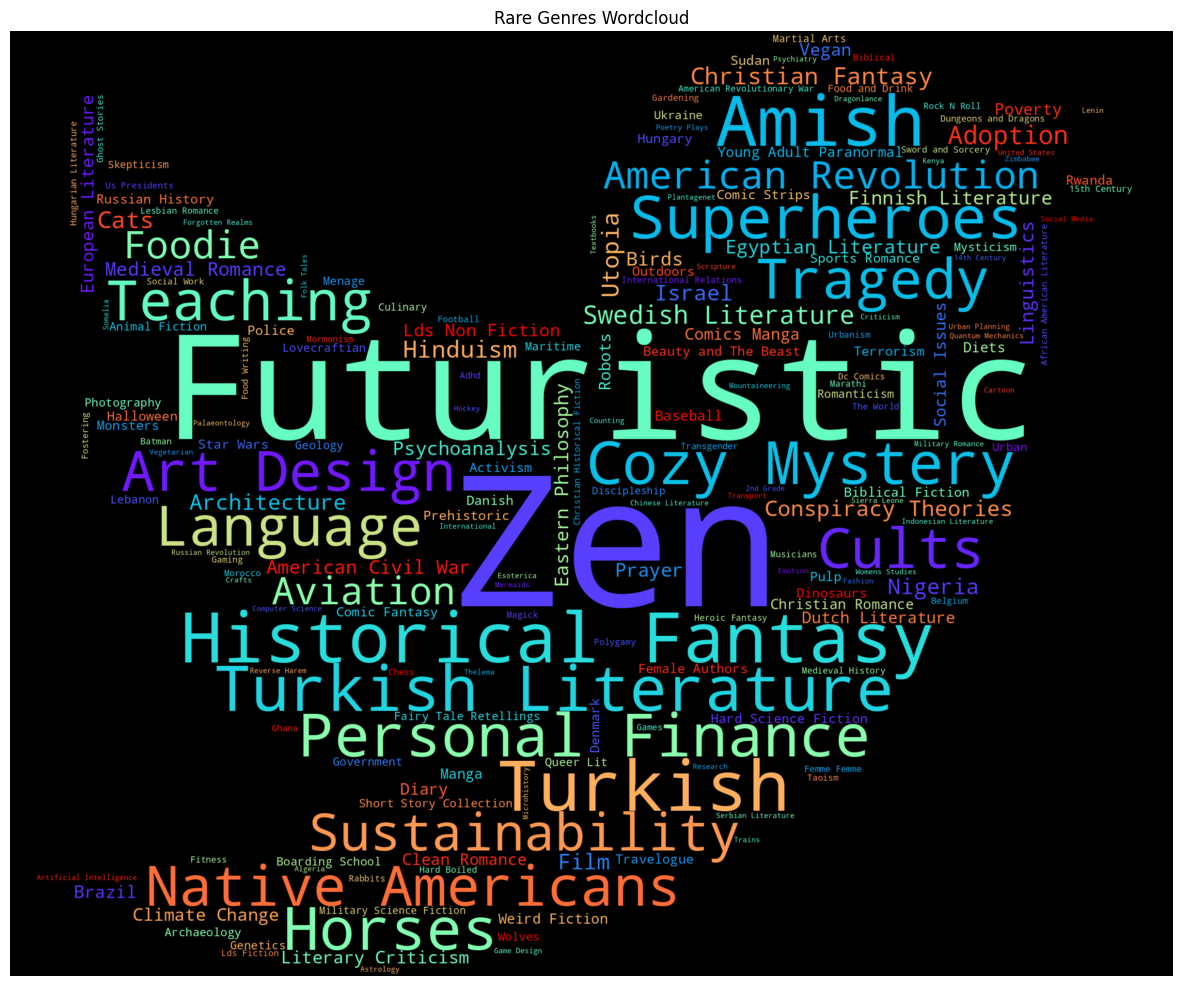

In [24]:
genre_count_rare = {key: value for key, value in genre_count.items() if value < threshold}

wordcloud = WordCloud(width=800, height=800, background_color='black',mask=mask,colormap="rainbow").generate_from_frequencies(genre_count_rare)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Rare Genres Wordcloud")
plt.show()

# Most Common Words From  Text

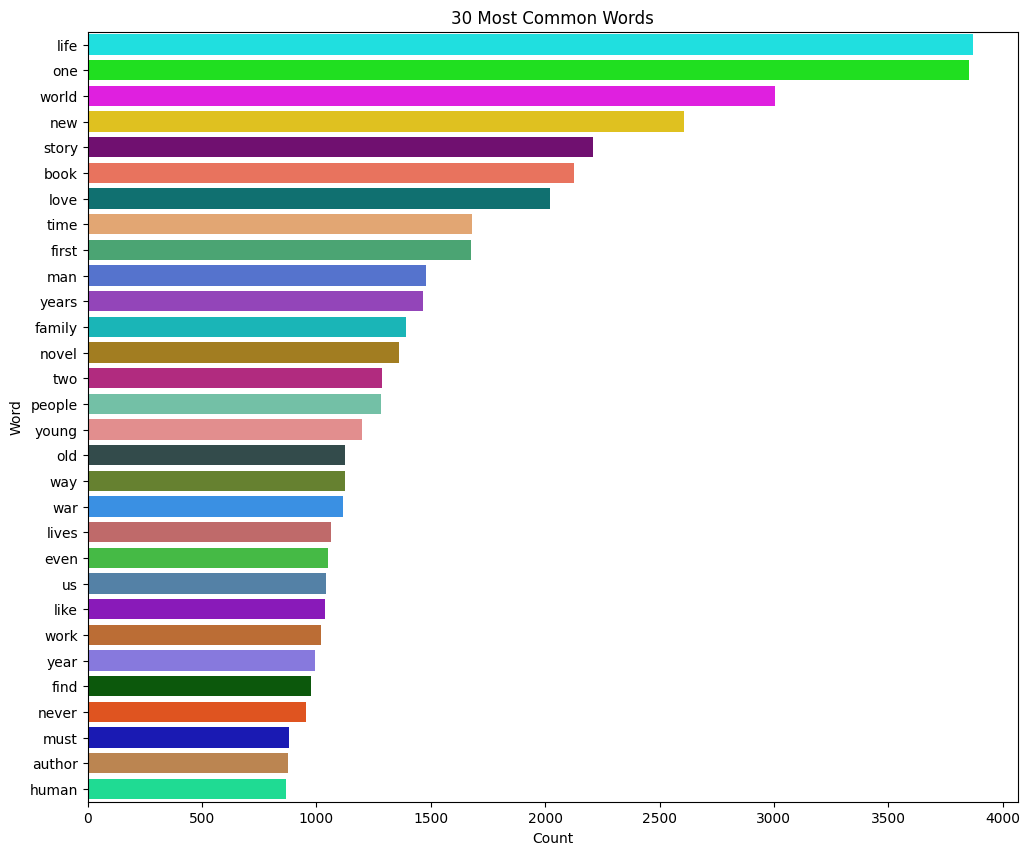

In [25]:
data_set =df["text"].str.split()
all_words = list(chain.from_iterable(data_set))
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

colors = ["cyan", "lime", "magenta", "gold", "purple", "tomato", "teal", "sandybrown", "mediumseagreen",
          "royalblue", "darkorchid", "darkturquoise", "darkgoldenrod", "mediumvioletred", "mediumaquamarine",
          "lightcoral", "darkslategray", "olivedrab", "dodgerblue", "indianred", "limegreen", "steelblue",
          "darkviolet", "chocolate", "mediumslateblue", "darkgreen", "orangered", "mediumblue", "peru", "mediumspringgreen"]

plt.figure(figsize=(12, 10))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)
plt.title('30 Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

In [26]:
df1.head()

,genres,text
0,"['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Read For School', 'Novels', 'High School']","To Kill a Mockingbird The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it. ""To Kill A Mockingbird"" became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic.Compassionate, dramatic, and deeply moving, ""To Kill A Mockingbird"" takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pathos. Now with over 18 million copie..."
1,"['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Classics', 'Adventure', 'Audiobook', 'Science Fiction Fantasy']","Harry Potter and the Philosopher’s Stone Harry Potter thinks he is an ordinary boy - until he is rescued by an owl, taken to Hogwarts School of Witchcraft and Wizardry, learns to play Quidditch and does battle in a deadly duel. The Reason ... HARRY POTTER IS A WIZARD!"
2,"['Classics', 'Fiction', 'Romance', 'Historical Fiction', 'Literature', 'Historical', 'Audiobook', 'Novels', 'Historical Romance', 'Adult']","Pride and Prejudice Alternate cover edition of ISBN 9780679783268Since its immediate success in 1813, Pride and Prejudice has remained one of the most popular novels in the English language. Jane Austen called this brilliant work ""her own darling child"" and its vivacious heroine, Elizabeth Bennet, ""as delightful a creature as ever appeared in print."" The romantic clash between the opinionated Elizabeth and her proud beau, Mr. Darcy, is a splendid performance of civilized sparring. And Jane Austen's radiant wit sparkles as her characters dance a delicate quadrille of flirtation and intrigue..."
3,"['Classics', 'Nonfiction', 'History', 'Biography', 'Memoir', 'Historical', 'Holocaust']","The Diary of a Young Girl Discovered in the attic in which she spent the last years of her life, Anne Frank’s remarkable diary has become a world classic—a powerful reminder of the horrors of war and an eloquent testament to the human spirit.In 1942, with the Nazis occupying Holland, a thirteen-year-old Jewish girl and her family fled their home in Amsterdam and went into hiding. For the next two years, until their whereabouts were betrayed to the Gestapo, the Franks and another family lived cloistered in the “Secret Annexe” of an old office building. Cut off from the outside world, they f..."
4,"['Classics', 'Fiction', 'Dystopia', 'Fantasy', 'Politics', 'Literature', 'School', 'Science Fiction', 'Novels', 'Read For School']","Animal Farm Librarian's note: There is an Alternate Cover Edition for this edition of this book here.A farm is taken over by its overworked, mistreated animals. With flaming idealism and stirring slogans, they set out to create a paradise of progress, justice, and equality. Thus the stage is set for one of the most telling satiric fables ever penned –a razor-edged fairy tale for grown-ups that records the evolution from revolution against tyranny to a totalitarianism just as terrible.When was first published, Stalinist Russia was seen as its target. Today it is devastatingly clear that whe..."


# One-Hot Encoding for Multilabel Classification

In [27]:
encode_genre_types = {key: idx for idx, key in enumerate(df['genres'].explode().unique())}

In [28]:
print(encode_genre_types)

{'Classics': 0, 'Fiction': 1, 'Historical Fiction': 2, 'School': 3, 'Literature': 4, 'Young Adult': 5, 'Historical': 6, 'Read For School': 7, 'Novels': 8, 'High School': 9, 'Fantasy': 10, 'Magic': 11, 'Childrens': 12, 'Middle Grade': 13, 'Adventure': 14, 'Audiobook': 15, 'Science Fiction Fantasy': 16, 'Romance': 17, 'Historical Romance': 18, 'Adult': 19, 'Nonfiction': 20, 'History': 21, 'Biography': 22, 'Memoir': 23, 'Holocaust': 24, 'Dystopia': 25, 'Politics': 26, 'Science Fiction': 27, 'France': 28, 'Philosophy': 29, 'French Literature': 30, 'American': 31, 'Coming Of Age': 32, 'Epic Fantasy': 33, 'High Fantasy': 34, 'War': 35, 'World War II': 36, 'Books About Books': 37, 'Gothic': 38, '19th Century': 39, 'Christian': 40, 'Christian Fiction': 41, 'Plays': 42, 'Drama': 43, 'Poetry': 44, 'Contemporary': 45, 'Picture Books': 46, 'Juvenile': 47, 'Short Stories': 48, 'Kids': 49, 'Animals': 50, 'Chapter Books': 51, 'Teen': 52, 'Post Apocalyptic': 53, 'Humor': 54, 'Food': 55, 'Horror': 56, 

In [29]:
categorical_genre_list = []
revised_genres_list = df['genres'].to_list()

for revised_genres in revised_genres_list:
    categorical_list = [0] * len(encode_genre_types)
    for genre in revised_genres:
        genre_type_index = encode_genre_types[genre]
        categorical_list[genre_type_index] = 1
    categorical_genre_list.append(categorical_list)

print(categorical_genre_list[0][:30])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [30]:
with open("genre_types_encoded.json", "w") as fp:
    json.dump(encode_genre_types, fp)

In [31]:
df1['genre_cat_list'] = categorical_genre_list
df1.head()

,genres,text,genre_cat_list
0,"['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Read For School', 'Novels', 'High School']","To Kill a Mockingbird The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it. ""To Kill A Mockingbird"" became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic.Compassionate, dramatic, and deeply moving, ""To Kill A Mockingbird"" takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pathos. Now with over 18 million copie...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,"['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Classics', 'Adventure', 'Audiobook', 'Science Fiction Fantasy']","Harry Potter and the Philosopher’s Stone Harry Potter thinks he is an ordinary boy - until he is rescued by an owl, taken to Hogwarts School of Witchcraft and Wizardry, learns to play Quidditch and does battle in a deadly duel. The Reason ... HARRY POTTER IS A WIZARD!","[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,"['Classics', 'Fiction', 'Romance', 'Historical Fiction', 'Literature', 'Historical', 'Audiobook', 'Novels', 'Historical Romance', 'Adult']","Pride and Prejudice Alternate cover edition of ISBN 9780679783268Since its immediate success in 1813, Pride and Prejudice has remained one of the most popular novels in the English language. Jane Austen called this brilliant work ""her own darling child"" and its vivacious heroine, Elizabeth Bennet, ""as delightful a creature as ever appeared in print."" The romantic clash between the opinionated Elizabeth and her proud beau, Mr. Darcy, is a splendid performance of civilized sparring. And Jane Austen's radiant wit sparkles as her characters dance a delicate quadrille of flirtation and intrigue...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,"['Classics', 'Nonfiction', 'History', 'Biography', 'Memoir', 'Historical', 'Holocaust']","The Diary of a Young Girl Discovered in the attic in which she spent the last years of her life, Anne Frank’s remarkable diary has become a world classic—a powerful reminder of the horrors of war and an eloquent testament to the human spirit.In 1942, with the Nazis occupying Holland, a thirteen-year-old Jewish girl and her family fled their home in Amsterdam and went into hiding. For the next two years, until their whereabouts were betrayed to the Gestapo, the Franks and another family lived cloistered in the “Secret Annexe” of an old office building. Cut off from the outside world, they f...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,"['Classics', 'Fiction', 'Dystopia', 'Fantasy', 'Politics', 'Literature', 'School', 'Science Fiction', 'Novels', 'Read For Sch

# Label_Data

In [32]:
labels = list(encode_genre_types.keys())
print(labels)

['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Read For School', 'Novels', 'High School', 'Fantasy', 'Magic', 'Childrens', 'Middle Grade', 'Adventure', 'Audiobook', 'Science Fiction Fantasy', 'Romance', 'Historical Romance', 'Adult', 'Nonfiction', 'History', 'Biography', 'Memoir', 'Holocaust', 'Dystopia', 'Politics', 'Science Fiction', 'France', 'Philosophy', 'French Literature', 'American', 'Coming Of Age', 'Epic Fantasy', 'High Fantasy', 'War', 'World War II', 'Books About Books', 'Gothic', '19th Century', 'Christian', 'Christian Fiction', 'Plays', 'Drama', 'Poetry', 'Contemporary', 'Picture Books', 'Juvenile', 'Short Stories', 'Kids', 'Animals', 'Chapter Books', 'Teen', 'Post Apocalyptic', 'Humor', 'Food', 'Horror', 'LGBT', 'Classic Literature', 'Civil War', 'Religion', 'Christianity', 'Reference', 'Spirituality', 'Theology', 'Comedy', 'Theatre', 'Essays', 'Fairy Tales', 'Writing', 'Literary Criticism', 'Mythology', 'Research', 'S

# Model IBert

In [33]:
from transformers import AutoTokenizer, AutoConfig, IBertForSequenceClassification
model_name="kssteven/ibert-roberta-base"
config = AutoConfig.from_pretrained("kssteven/ibert-roberta-base")
config.num_labels = len(labels)
model_cls =IBertForSequenceClassification
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [34]:
from blurr.text.data.core import TextBlock

blocks = (TextBlock(hf_arch=hf_arch, hf_config=hf_config, 
                       hf_tokenizer=hf_tokenizer, hf_model=hf_model, 
                       max_length=512), 
                       MultiCategoryBlock(encoded=True, vocab=labels))

dblock = DataBlock(blocks=blocks,
                  get_x=ColReader('text'),
                  get_y=ColReader('genre_cat_list'),
                  splitter=RandomSplitter(valid_pct=0.2, seed=42))

In [35]:
dls = dblock.dataloaders(df1, bs=8)
os.makedirs("/kaggle/working/dataloader", exist_ok=True)
torch.save(dls, "/kaggle/working/dataloader/book_genre_classifier.pkl")

In [36]:
dls = torch.load("/kaggle/working/dataloader/book_genre_classifier.pkl")

In [37]:
dls.vocab

['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical', 'Read For School', 'Novels', 'High School', 'Fantasy', 'Magic', 'Childrens', 'Middle Grade', 'Adventure', 'Audiobook', 'Science Fiction Fantasy', 'Romance', 'Historical Romance', 'Adult', 'Nonfiction', 'History', 'Biography', 'Memoir', 'Holocaust', 'Dystopia', 'Politics', 'Science Fiction', 'France', 'Philosophy', 'French Literature', 'American', 'Coming Of Age', 'Epic Fantasy', 'High Fantasy', 'War', 'World War II', 'Books About Books', 'Gothic', '19th Century', 'Christian', 'Christian Fiction', 'Plays', 'Drama', 'Poetry', 'Contemporary', 'Picture Books', 'Juvenile', 'Short Stories', 'Kids', 'Animals', 'Chapter Books', 'Teen', 'Post Apocalyptic', 'Humor', 'Food', 'Horror', 'LGBT', 'Classic Literature', 'Civil War', 'Religion', 'Christianity', 'Reference', 'Spirituality', 'Theology', 'Comedy', 'Theatre', 'Essays', 'Fairy Tales', 'Writing', 'Literary Criticism', 'Mythology', 'Research', 'S

In [38]:

dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,الصوت روح في مجال المسرح و الشعر ، و فى المجال الأدبي عموما معروف.. ان هناك ادب بيتم تطويع المواضيع و الافكار له..، و ادب بيتم تطويعه و استخدامه لعرض الافكار و المواضيع من خلالهفي المسرح مثلا عندنا تجارب لتوفيق الحكيم و لدكتور مصطفى محمود من مسرحيات هي فنيا قد تكون غير صالحة باعتراف اصحابها ذاتهم.. لكنها على مستوى عرض الموضوع و الفكرة ناجحة طبعا..،كذلك فى الشعر.. هناك اشعار بيتم تطويع المواضيع و الأفكار لها.. و هناك اشعار بيتم تطويعها و استخدامها لعرض الافكار و المواضيع و الأحداث.. الشئ اللى بيجعل الجانب ا,"[Literature, Nonfiction, Philosophy, Poetry, Spirituality, Inspirational, Islam, Mountaineering]"
1,"Lendas e Narrativas Biblioteca Ulisseia de Autores Portugueses #27Publicadas em dois volumes, em 1851, estas “Lendas e Narrativas” de Alexandre Herculano são uma coletâneo de histórias publicadas entre 1839 e 1844 nas revistas O Panorama e A Ilustração.Os contos das “Lendas e Narrativas” são:A Destruição de Áuria – Conto do Século VIII, sobre a destruição da cidade visigótica de Áuria (atual Ourense) pela invasão dos mouros na Península Ibérica.O Alcaide de Santarém – Conto do Século X, tendo como pano de","[Classics, Romance, Short Stories, Portuguese Literature]"
2,"الرحيق المختوم الرحيق المختومبحث في السيرة النبوية.تأليف: الشيخ صفي الرحمن المباركفوري.قُدِّم في مسابقة رابطة العالم الإسلامي في السيرة النبوية الشريفة، وحاز البحث على المركز الأول.""ومن منهجي في هذا الكتاب ـ عدا ما جاء في إعلان الرابطة ـ أني قررت سلوك سبيل الاعتدال، متجنبًا التطويل الممل والإيجاز المخل، وقد وجدت المصادر تختلف فيما بينها حول كثير مما يتعلق بالأحداث اختلافًا لا يحتمل الجمع والتوفيق، فاخترت سبيل الترجيح، وأثبت في الكتاب ما ترجح لدي بعد التدقيق في الدراسة والنقد، إلا أني طويت ذكر الدلائل والوج","[Classics, Historical, Nonfiction, History, Biography, Religion, Spirituality, Theology, Unfinished, Islam]"
3,"Missoula: Rape and the Justice System in a College Town From bestselling author Jon Krakauer, a stark, powerful, meticulously reported narrative about a series of sexual assaults at the University of Montana ­— stories that illuminate the human drama behind the national plague of campus rape.Missoula, Montana, is a typical college town, with a highly regarded state university, bucolic surroundings, a lively social scene, and an excellent football team — the Grizzlies — with a rabid fan base.The Department","[Audiobook, Adult, Nonfiction, History, Politics, Feminism, Crime, True Crime, World History, American Revolution]"


In [39]:


model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()



# Stage - 0

In [40]:
learner.freeze()

SuggestedLRs(slide=0.0012022644514217973, valley=0.0002290867705596611)

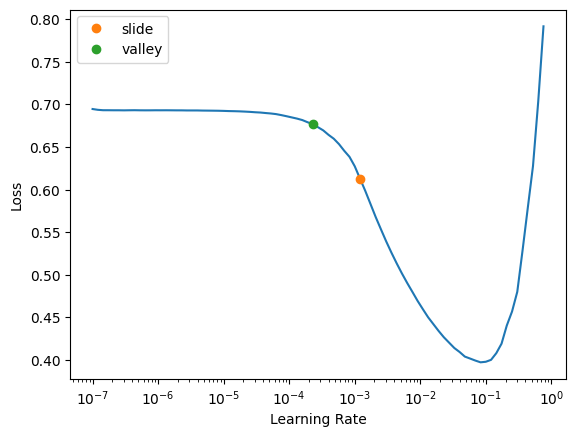

In [41]:
learner.lr_find(suggest_funcs=[slide, valley])

In [42]:
learner.fit_one_cycle(10,0.0004)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.057329,0.051962,0.980643,01:28
1,0.052971,0.051989,0.978932,01:28
2,0.051916,0.050943,0.980141,01:28
3,0.047730,0.047597,0.982399,01:28
4,0.045513,0.045003,0.983963,01:27
5,0.042986,0.043082,0.984219,01:27
6,0.042715,0.041758,0.984045,01:27
7,0.042267,0.041180,0.984739,01:27
8,0.040988,0.040743,0.984811,01:27
9,0.040906,0.040735,0.984836,01:27


In [43]:

learner.save("/kaggle/working/book_genre_classifier_0")

Path('/kaggle/working/book_genre_classifier_0.pth')

In [44]:
learner.export("/kaggle/working/book_genre_classifier_0.pkl")

# Stage_1

In [45]:
learner.load("/kaggle/working/book_genre_classifier_0")

In [46]:
learner.unfreeze()

SuggestedLRs(slide=0.0010000000474974513, valley=3.630780702224001e-05)

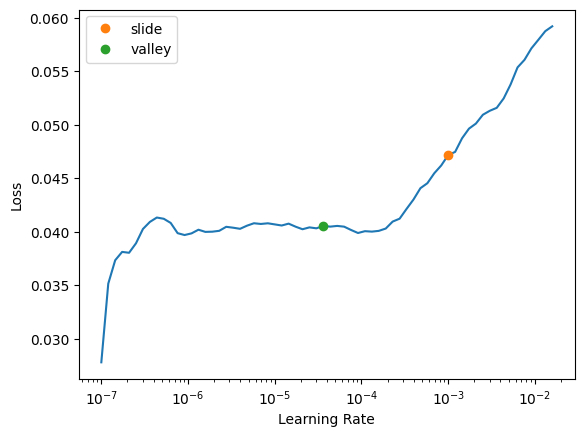

In [47]:
learner.lr_find(suggest_funcs=[slide, valley])

In [48]:
learner.fit_one_cycle(10,slice(4.75e-3, 2.25e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.041181,0.041778,0.983527,03:00
1,0.053185,0.052449,0.982380,02:59
2,0.052089,0.051513,0.979533,02:59
3,0.051834,0.051643,0.978840,03:00
4,0.052210,0.051457,0.979909,02:59
5,0.051785,0.051343,0.980974,02:59
6,0.051225,0.051487,0.978061,03:00
7,0.051425,0.051361,0.979909,03:00
8,0.051456,0.051361,0.979909,03:00
9,0.051277,0.051332,0.980959,03:00


In [49]:
learner.save("/kaggle/working/book_genre_classifier_1")

Path('/kaggle/working/book_genre_classifier_1.pth')

In [50]:
learner.export("/kaggle/working/book_genre_classifier_1.pkl")

# Split Data

In [51]:
splitter = RandomSplitter(valid_pct=0.3, seed=42)
train_ids, valid_ids = splitter(df1)
len(train_ids), len(valid_ids)

(4392, 1882)

In [52]:
valid_df = df1.loc[valid_ids]
valid_df.head()

,genres,text,genre_cat_list
2764,"['Fiction', 'Historical Fiction', 'Contemporary', 'Literary Fiction', 'Romance', 'British Literature', 'Literature', 'Novels', 'Adult', 'Historical']","On Chesil Beach A novel of remarkable depth and poignancy from one of the most acclaimed writers of our time.It is July 1962. Florence is a talented musician who dreams of a career on the concert stage and of the perfect life she will create with Edward, an earnest young history student at University College of London, who unexpectedly wooed and won her heart. Newly married that morning, both virgins, Edward and Florence arrive at a hotel on the Dorset coast. At dinner in their rooms they struggle to suppress their worries about the wedding night to come. Edward, eager for rapture, frets o...","[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...]"
1239,"['Mystery', 'Thriller', 'Fiction', 'Mystery Thriller', 'Crime', 'Suspense', 'Audiobook', 'Contemporary', 'Adult', 'Detective']","My Sister's Grave Tracy Crosswhite has spent twenty years questioning the facts surrounding her sister Sarah’s disappearance and the murder trial that followed. She doesn’t believe that Edmund House — a convicted rapist and the man condemned for Sarah’s murder — is the guilty party. Motivated by the opportunity to obtain real justice, Tracy became a homicide detective with the Seattle PD and dedicated her life to tracking down killers.When Sarah’s remains are finally discovered near their hometown in the northern Cascade mountains of Washington State, Tracy is determined to get the answers...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1630,"['Fantasy', 'Urban Fantasy', 'Fiction', 'Horror', 'Vampires', 'Paranormal', 'Russia', 'Supernatural', 'Science Fiction', 'Magic']","Night Watch Others. They walk among us. Observing.Set in contemporary Moscow, where shape shifters, vampires, and street-sorcerers linger in the shadows, Night Watch is the first book of the hyper-imaginative fantasy pentalogy from best-selling Russian author Sergei Lukyanenko.This epic saga chronicles the eternal war of the “Others,” an ancient race of humans with supernatural powers who must swear allegiance to either the Dark or the Light. The agents of the Dark – the Night Watch – oversee nocturnal activity, while the agents of the Light keep watch over the day. For a thousand years bo...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1874,"['Fantasy', 'Young Adult', 'Romance', 'Mythology', 'Paranormal', 'Magic', 'Adventure', 'Fiction', 'Dragons', 'Urban Fantasy']","Tiger's Voyage With the head-to-head battle against the villainous Lokesh behind her, Kelsey confronts a new heartbreak: in the wake of his traumatic experience, her beloved Ren no longer remembers who she is. As the trio continues their quest by challenging five cunning and duplicitous dragons, Ren and Kishan once more vie for her affections--leaving Kelsey more confused than ever.","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Fastai & Blurr Inference

In [53]:
model_path = "/kaggle/working/book_genre_classifier_0.pkl"
learner_inf = load_learner(model_path)

In [54]:
learner_inf.blurr_predict("This book genre is characterized by elements of magic or the supernatural and is often inspired by mythology or folklore. In high fantasy — one that’s set in an entirely fictional world — these magical elements are at the forefront of the plot, as in Trudi Canavan’s Black Magician trilogy. In low fantasy or magical realism, however, magic is subtly woven into an otherwise familiar, real-world setting.")

[{'labels': ['Fiction'],
  'scores': [0.8140709400177002],
  'class_indices': [0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,


In [55]:
learner_inf.blurr_predict("This book genre is characterized by elements of magic or the supernatural and is often inspired by mythology or folklore. In high fantasy — one that’s set in an entirely fictional world — these magical elements are at the forefront of the plot, as in Trudi Canavan’s Black Magician trilogy. In low fantasy or magical realism, however, magic is subtly woven into an otherwise familiar, real-world setting.")[0]["labels"]

['Fiction']

In [56]:
from sklearn import metrics

def metric_measures(test_df, preds):

  targets = [np.asarray(target) for target in test_df['genre_cat_list'].to_list()]
  outputs = [np.asarray(pred) for pred in preds]


  accuracy = metrics.accuracy_score(targets, outputs)
  f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
  f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

  print(f"F1 Score (Micro) = {f1_score_micro}")
  print(f"F1 Score (Macro) = {f1_score_macro}")

  return

In [57]:
from tqdm.notebook import tqdm

preds = []
for idx, row in tqdm(valid_df.iterrows(), total=len(valid_df)):
  desc = row['text']
  labels = learner_inf.blurr_predict(desc)[0]['labels']
  pred_genres = [0] * len(encode_genre_types)
  for label in labels:
    pred_genres[encode_genre_types[label]] = 1
  preds.append(pred_genres)

preds[0][:20]

  0%|          | 0/1882 [00:00<?, ?it/s]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [58]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.31796635375034854
F1 Score (Macro) = 0.015477621832454144


# Convert to ONNX


**ONNX (Open Neural Network Exchange) is an open format for deep learning models, enabling seamless sharing and interoperability between frameworks like PyTorch, TensorFlow, and Caffe2. It simplifies optimization and acceleration on various hardware platforms, including GPUs and TPUs. ONNX also promotes collaboration by standardizing model formats and provides tools like ONNX Runtime for efficient model execution and converters for cross-framework compatibility.**

In [59]:
os.makedirs("/kaggle/working/onnx",exist_ok=True)

In [60]:

classifier = learner_inf.model.hf_model.eval()
torch.onnx.export(classifier,torch.LongTensor([[0] * 512]),'/kaggle/working/onnx/book_genres_classifier.onnx',
    input_names=['input_ids'],
    output_names=['output'],
    opset_version=13,
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence_len'},
        'output': {0: 'batch_size'}})

In [61]:
from onnxruntime.quantization import quantize_dynamic, QuantType
onnx_model_path = '/kaggle/working/onnx/book_genres_classifier.onnx'
quantized_onnx_model_path = '/kaggle/working/onnx/book_genres_classifier_quantized.onnx'

quantize_dynamic(onnx_model_path,quantized_onnx_model_path,weight_type=QuantType.QUInt8)

In [62]:
import onnxruntime as rt


tokenizer = AutoTokenizer.from_pretrained("kssteven/ibert-roberta-base")
class_labels = list(encode_genre_types.keys())

inf_session = rt.InferenceSession('/kaggle/working/onnx/book_genres_classifier.onnx')
input_name = inf_session.get_inputs()[0].name
output_name = inf_session.get_outputs()[0].name

In [63]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=valid_df.shape[0]):
  desc = row['text']
  input_ids = tokenizer(desc)['input_ids'][:512]

  probs = inf_session.run([output_name], {input_name: [input_ids]})[0]
  probs = torch.FloatTensor(probs)

  masks = torch.sigmoid(probs) >= 0.5
  labels = [class_labels[idx] for idx, mask in enumerate(masks[0]) if mask]

  pred_genres = [0] * len(encode_genre_types)
  for label in labels:
    pred_genres[encode_genre_types[label]] = 1
  preds.append(pred_genres)

  0%|          | 0/1882 [00:00<?, ?it/s]

In [64]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.31962495358336424
F1 Score (Macro) = 0.01568546711102761


# Quantized ONNX

In [65]:

class_labels = list(encode_genre_types.keys())

inf_session = rt.InferenceSession('/kaggle/working/onnx/book_genres_classifier_quantized.onnx')
input_name = inf_session.get_inputs()[0].name
output_name = inf_session.get_outputs()[0].name

In [66]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=valid_df.shape[0]):
  desc = row['text']
  input_ids = tokenizer(desc)['input_ids'][:512]

  probs = inf_session.run([output_name], {input_name: [input_ids]})[0]
  probs = torch.FloatTensor(probs)

  masks = torch.sigmoid(probs) >= 0.5
  labels = [class_labels[idx] for idx, mask in enumerate(masks[0]) if mask]

  pred_genres = [0] * len(encode_genre_types)
  for label in labels:
    pred_genres[encode_genre_types[label]] = 1
  preds.append(pred_genres)

  0%|          | 0/1882 [00:00<?, ?it/s]

In [67]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.25070103802823834
F1 Score (Macro) = 0.010486146060311608
